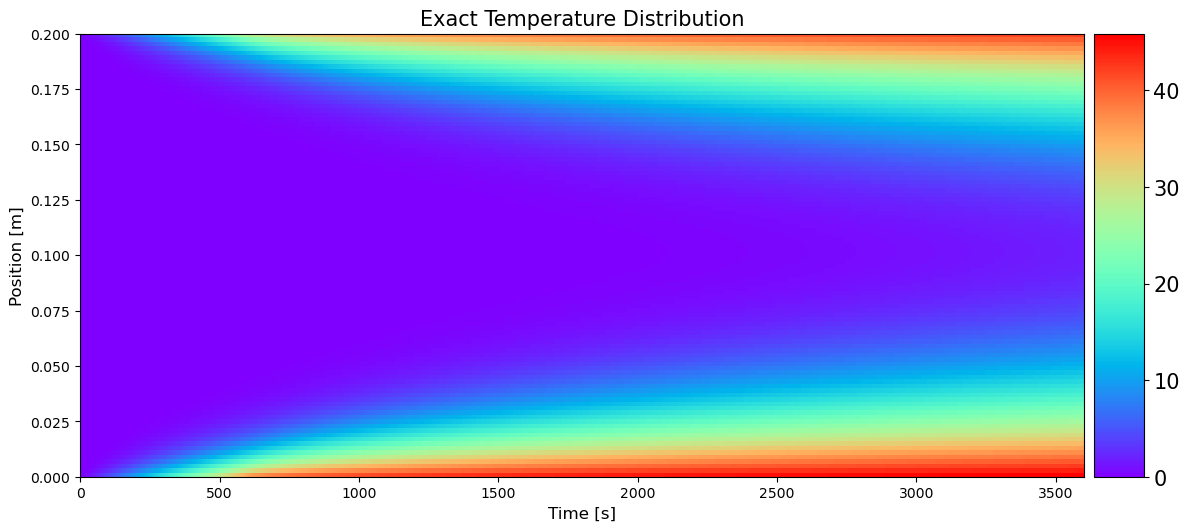

Epoch 0: Total Loss: 1.7472e+00, Loss f: 1.7008e+00, Loss BC0: 1.7707e-02, Loss BC1: 1.4893e-02, Loss BC2: 1.3871e-02
lambda_f: 1.1022353172302246, lambda_BC0: 1.001013994216919, lambda_BC1: 1.0008527040481567, lambda_BC2: 1.0007941722869873
Epoch 100: Total Loss: 5.1429e-02, Loss f: 3.1423e-03, Loss BC0: 5.2014e-03, Loss BC1: 3.5177e-03, Loss BC2: 3.5865e-03
lambda_f: 7.311793327331543, lambda_BC0: 2.658506393432617, lambda_BC1: 2.100677967071533, lambda_BC2: 2.1239476203918457
Epoch 200: Total Loss: 1.2031e-02, Loss f: 7.8591e-04, Loss BC0: 2.1228e-04, Loss BC1: 1.3372e-05, Loss BC2: 1.4899e-05
lambda_f: 14.048972129821777, lambda_BC0: 4.639401435852051, lambda_BC1: 2.7427303791046143, lambda_BC2: 2.7949790954589844
Epoch 300: Total Loss: 7.3853e-03, Loss f: 2.9525e-04, Loss BC0: 4.2027e-05, Loss BC1: 4.8769e-05, Loss BC2: 4.5629e-05
lambda_f: 23.473793029785156, lambda_BC0: 5.0337677001953125, lambda_BC1: 2.8481483459472656, lambda_BC2: 2.8947620391845703
Epoch 400: Total Loss: 5.66

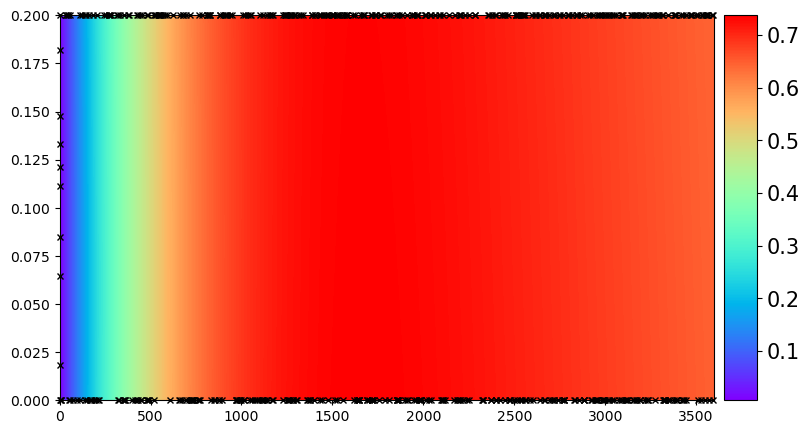

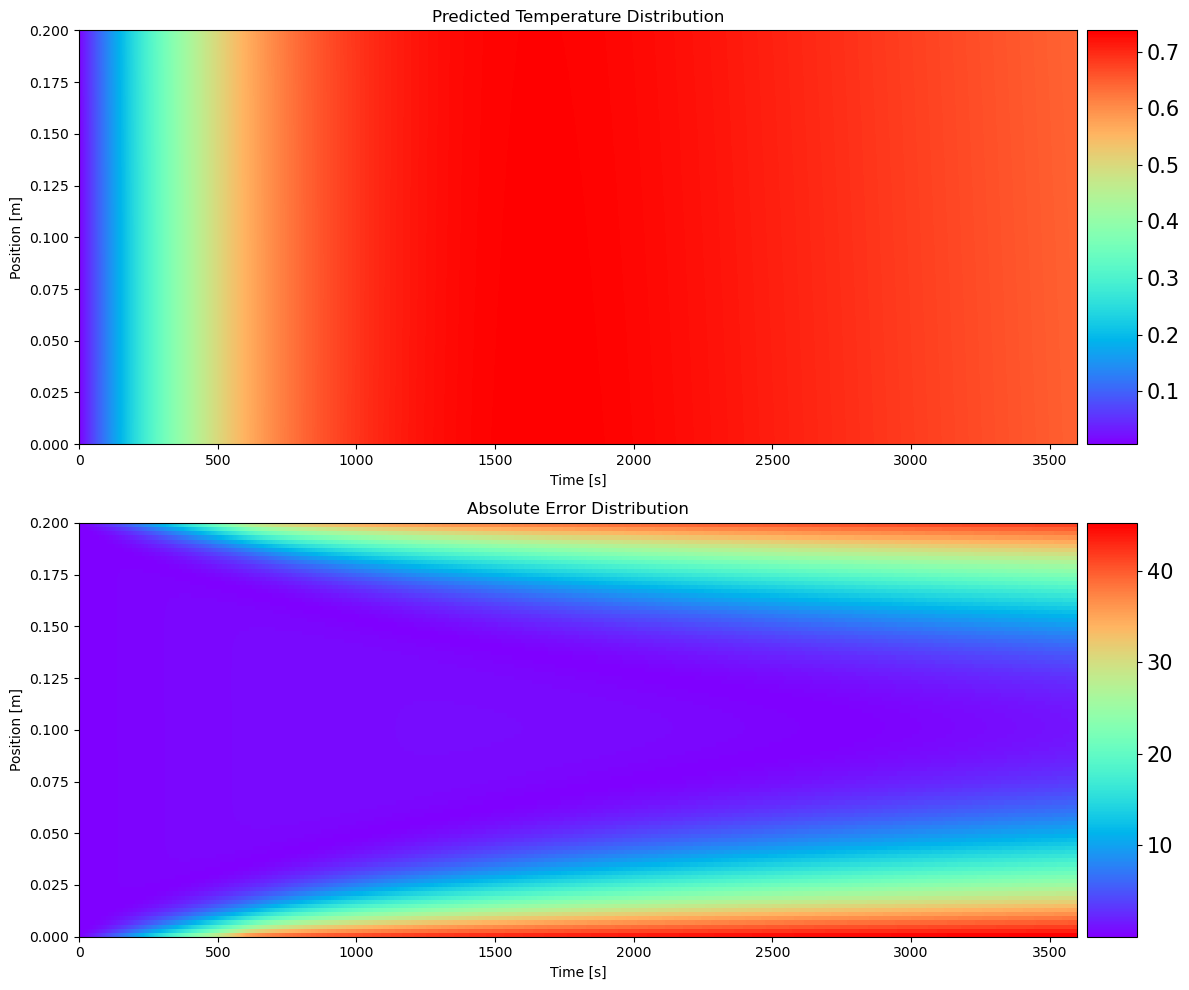

In [28]:
#xとtとuのスケーリング
#ver2
#希望ある。
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

np.random.seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)

h1 = 100
h2 = 50

lambda_u, lambda_f, lambda_BC0, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0, 1.0 

N_u = 500
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

x = np.linspace(0, 0.2, 100)[:, None]
t = np.linspace(0, 3600, 3600)[:, None]
dx = x[1] - x[0]
dt = t[1] - t[0]

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
h_img1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Exact Temperature Distribution', fontsize=15)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Position [m]', fontsize=12)
plt.tight_layout()
plt.show()

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.flatten()[:, None]

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)
# print(lb, ub)
# [0. 0.] [2.0e-01 3.6e+03]

# 初期条件と境界条件のデータを準備
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = u[0:1, :].T
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = u[:, 0:1]
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = u[:, -1:]

# xx1は初期条件。uu1はt=0の時の温度分布
# print('xx1:', xx1.shape)→(100, 2)
# print('uu1:', uu1.shape)→(100, 1)
# xx2はx=0の境界条件。uu2はx=0の境界条件の温度分布
# print('xx2:', xx2.shape)→(3600, 2)
# print('xx2[:, 0:1]:', xx2[:, 0:1])
# print('uu2:', uu2.shape)
# print('uu2[:, 0:1]:', uu2[:, 0:1])
# xx3はx=0.2の境界条件。uu3はx=0.2の境界条件の温度分布
# print('xx3:', xx3.shape)→(3600, 2)
# print('xx3[:, -1:]:', xx3[:, -1:])
# print('uu3:', uu3.shape)
# print('uu3[:, -1:]:', uu3[:, -1:])

# 初期・境界条件のデータを結合
X_u_train = np.vstack([xx1, xx2, xx3])
# print('X_u_train:', X_u_train.shape)→(7300, 2)。3600+3600+100=7300

# ランダムサンプリング
X_f_train = lb + (ub - lb) * lhs(2, N_f)
# print('X_f_train:', X_f_train.shape)→(10000, 2)
# print('X_f_train:', X_f_train)

#ランダムサンプリングのデータと初期・境界条件のデータを結合
X_f_train = np.vstack((X_f_train, X_u_train))
# print('X_f_train:', X_f_train.shape)→(17300, 2)
# print('X_f_train.tail:', X_f_train[-1])

# 初期・境界条件での温度分布
u_train = np.vstack([uu1, uu2, uu3])
# print('u_train:', u_train.shape)→(500,1)

# X_u_trainの行数からN_u個のランダムなインデックスを生成。
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# 初期・境界条件のデータをN_u個に絞る
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

# まとめ
# X_u_train: 初期・境界条件の位置・時間データ
# u_train: 初期・境界条件の温度データ
# X_f_train: ランダムサンプリングの位置・時間データ

def scale_x(x):
    return 2.0 * (x - lb[0]) / (ub[0] - lb[0]) - 1.0

def scale_t(t):
    return (t - lb[1]) / (ub[1] - lb[1])

def scale_u(u):
    return (u - u_min) / (u_max - u_min)

def unscale_x(x):
    return 0.5 * (x + 1.0) * (ub[0] - lb[0]) + lb[0]

def unscale_t(t):
    return t * (ub[1] - lb[1]) + lb[1]

def unscale_u(u, u_min, u_max):
    return u * (u_max - u_min) + u_min

# 初期・境界条件・ランダムサンプリングのデータをスケーリング
X_u_train_scaled = np.copy(X_u_train)
X_u_train_scaled[:, 0] = scale_x(X_u_train[:, 0])
X_u_train_scaled[:, 1] = scale_t(X_u_train[:, 1])

X_f_train_scaled = np.copy(X_f_train)
X_f_train_scaled[:, 0] = scale_x(X_f_train[:, 0])
X_f_train_scaled[:, 1] = scale_t(X_f_train[:, 1])

# print('X_u_train_scaled:', X_u_train_scaled[:10])
# print('X_f_train_scaled:', X_f_train_scaled[:10])
# print('X_u_train_scaleの位置の最小値:', X_u_train_scaled[:, 0].min()):-1
# print('X_u_train_scaleの位置の最大値:', X_u_train_scaled[:, 0].max()):1
# print('X_u_train_scaleの時間の最小値:', X_u_train_scaled[:, 1].min()):0
# print('X_u_train_scaleの時間の最大値:', X_u_train_scaled[:, 1].max()):1
# print('X_f_train_scaleの位置の最小値:', X_f_train_scaled[:, 0].min()):-1
# print('X_f_train_scaleの位置の最大値:', X_f_train_scaled[:, 0].max()):1
# print('X_f_train_scaleの時間の最小値:', X_f_train_scaled[:, 1].min()):0
# print('X_f_train_scaleの時間の最大値:', X_f_train_scaled[:, 1].max()):1

# 温度データのスケーリング
# 設定変える時はここも変える
u_min, u_max = 0, 50
u_train_scaled = scale_u(u_train)
# print('u_min', u_min):0
# print('u_max', u_max):45.880
# print('u_train_scaled:', u_train_scaled[:10])
# print('u_train_scaledの最小値:', u_train_scaled.min()):0
# print('u_train_scaledの最大値:', u_train_scaled.max()):1.0

T0 = u_train[X_u_train[:,1] == 0].mean().item()
T0_scaled = scale_u(T0)
# print('T0:', T0):0.0

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.ELU
        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, rho, cp, alpha, k, h1, h2, T0):
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.layers = layers
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        self.T0 = T0
        self.dnn = DNN(layers).to(device)
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)
        self.lambda_f = torch.tensor(lambda_f, requires_grad=True, device=device)
        self.lambda_BC0 = torch.tensor(lambda_BC0, requires_grad=True, device=device)
        self.lambda_BC1 = torch.tensor(lambda_BC1, requires_grad=True, device=device)
        self.lambda_BC2 = torch.tensor(lambda_BC2, requires_grad=True, device=device)

    def net_t_inf(self, t):
        t_unscaled = unscale_t(t)
        t_inf_unscaled = torch.where(t_unscaled <= 600, 50 * t_unscaled / 600, torch.tensor(50.0).to(device))
        t_inf = scale_t(t_inf_unscaled)
        return t_inf

    def net_u(self, x, t):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = self.alpha * u_xx - u_t
        return f

    def net_BC0(self, x):
        t = torch.zeros_like(x)
        u = self.net_u(x, t)
        BC0 = self.T0 - u
        return BC0

    def net_BC1(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC1 = - (t_inf - u) + (self.k / self.h1) * u_x
        return BC1

    def net_BC2(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2

    def loss_func(self):
        f_pred = self.net_f(self.x_f, self.t_f)
        x_BC0 = self.x_f[self.t_f == 0]
        BC0_pred = self.net_BC0(x_BC0)
        x_BC1 = torch.full((self.t_f.shape[0], 1), 1.0, requires_grad=True).to(device)
        t_BC1 = self.t_f
        BC1_pred = self.net_BC1(x_BC1, t_BC1)
        x_BC2 = torch.full((self.t_f.shape[0], 1), -1.0, requires_grad=True).to(device)
        t_BC2 = self.t_f
        BC2_pred = self.net_BC2(x_BC2, t_BC2)
        loss_f = torch.mean(f_pred**2)
        loss_BC0 = torch.mean(BC0_pred**2)
        loss_BC1 = torch.mean(BC1_pred**2)
        loss_BC2 = torch.mean(BC2_pred**2)
        total_loss = self.lambda_f * loss_f + self.lambda_BC0 * loss_BC0 + self.lambda_BC1 * loss_BC1 + self.lambda_BC2 * loss_BC2
        return total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2

    def train(self, nIter):
        for epoch in range(nIter):
            self.optimizer_Adam.zero_grad()
            total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2 = self.loss_func()
            total_loss.backward()
            self.optimizer_Adam.step()
            with torch.no_grad():
                self.lambda_f *= torch.exp(0.1 * loss_f.detach() / total_loss.detach())
                self.lambda_BC0 *= torch.exp(0.1 * loss_BC0.detach() / total_loss.detach())
                self.lambda_BC1 *= torch.exp(0.1 * loss_BC1.detach() / total_loss.detach())
                self.lambda_BC2 *= torch.exp(0.1 * loss_BC2.detach() / total_loss.detach())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}: Total Loss: {total_loss.item():.4e}, Loss f: {loss_f.item():.4e}, Loss BC0: {loss_BC0.item():.4e}, Loss BC1: {loss_BC1.item():.4e}, Loss BC2: {loss_BC2.item():.4e}')
                print(f'lambda_f: {self.lambda_f.item()}, lambda_BC0: {self.lambda_BC0.item()}, lambda_BC1: {self.lambda_BC1.item()}, lambda_BC2: {self.lambda_BC2.item()}')

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)
        x_star_scaled = scale_x(x_star)
        t_star_scaled = scale_t(t_star)
        u_pred_scaled = self.net_u(x_star_scaled, t_star_scaled)
        u_pred = unscale_u(u_pred_scaled, 0, 50)
        return u_pred.detach().cpu().numpy()

# モデルのインスタンス化
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, K, h1, h2, T0)
model = PhysicsInformedNN(X_u_train_scaled, u_train_scaled, X_f_train_scaled, layers, lb, ub, alpha, rho, cp, K, h1, h2, T0_scaled)

# モデルのトレーニング
model.train(15000)

# 予測
u_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h_img2 = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h_img2, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)

# 誤差の計算
Error = np.abs(u - U_pred)

# 温度分布の可視化
fig = plt.figure(figsize=(12, 10))

# 予測温度分布
ax1 = fig.add_subplot(211)
h_img3 = ax1.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img3, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Predicted Temperature Distribution')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Position [m]')

# 残差の可視化
ax2 = fig.add_subplot(212)
h_img4 = ax2.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.10)
cbar2 = fig.colorbar(h_img4, cax=cax2)
cbar2.ax.tick_params(labelsize=15)
ax2.set_title('Absolute Error Distribution')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Position [m]')

plt.tight_layout()
plt.show()

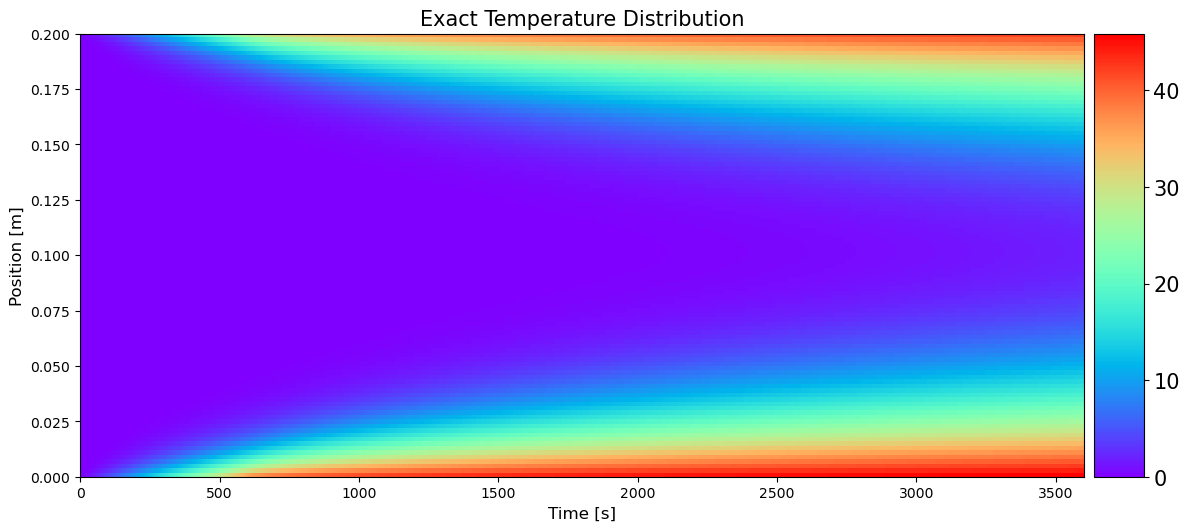

Epoch 0: Total Loss: 6.0729e+00, Loss f: 6.0708e+00, Loss BC0: 1.0966e-03, Loss BC1: 2.3117e-04, Loss BC2: 7.2014e-04
lambda_f: 1.1051336526870728, lambda_BC0: 1.0000180006027222, lambda_BC1: 1.0000038146972656, lambda_BC2: 1.0000118017196655
Epoch 100: Total Loss: 3.0002e-02, Loss f: 2.6939e-03, Loss BC0: 9.9681e-05, Loss BC1: 1.3676e-05, Loss BC2: 1.6886e-05
lambda_f: 11.187756538391113, lambda_BC0: 1.0270811319351196, lambda_BC1: 1.0039098262786865, lambda_BC2: 1.0032556056976318
Epoch 200: Total Loss: 1.6460e-02, Loss f: 7.7558e-04, Loss BC0: 5.9853e-05, Loss BC1: 2.8692e-05, Loss BC2: 3.3127e-05
lambda_f: 21.1597957611084, lambda_BC0: 1.060335397720337, lambda_BC1: 1.0161054134368896, lambda_BC2: 1.0175247192382812
Epoch 300: Total Loss: 1.1060e-02, Loss f: 3.5270e-04, Loss BC0: 6.0711e-05, Loss BC1: 2.9416e-05, Loss BC2: 3.2573e-05
lambda_f: 31.082361221313477, lambda_BC0: 1.1095203161239624, lambda_BC1: 1.038294792175293, lambda_BC2: 1.0426746606826782
Epoch 400: Total Loss: 7.2

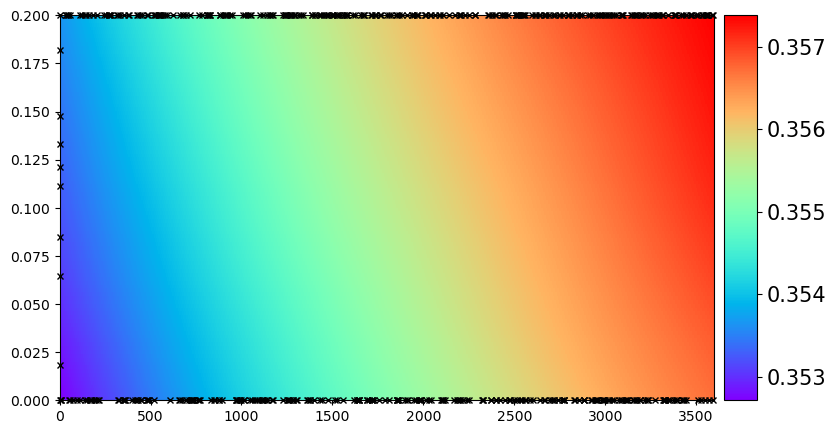

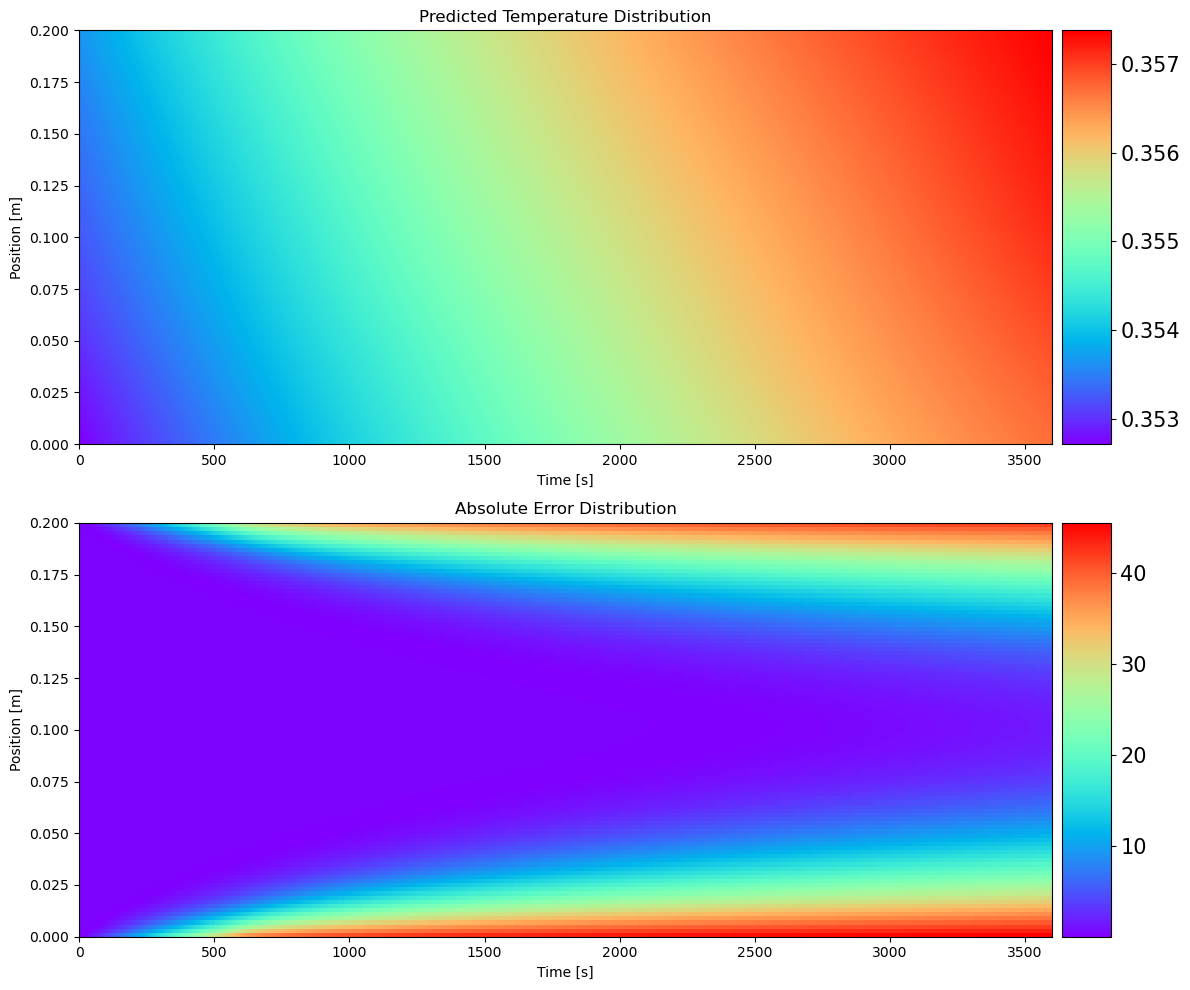

In [29]:
#xとtとuのスケーリング
#ver2
#希望ある。
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

np.random.seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)

h1 = 100
h2 = 50

lambda_u, lambda_f, lambda_BC0, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0, 1.0 

N_u = 500
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

x = np.linspace(0, 0.2, 100)[:, None]
t = np.linspace(0, 3600, 3600)[:, None]
dx = x[1] - x[0]
dt = t[1] - t[0]

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
h_img1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Exact Temperature Distribution', fontsize=15)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('Position [m]', fontsize=12)
plt.tight_layout()
plt.show()

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.flatten()[:, None]

# ドメインの境界
lb = X_star.min(0)
ub = X_star.max(0)
# print(lb, ub)
# [0. 0.] [2.0e-01 3.6e+03]

# 初期条件と境界条件のデータを準備
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = u[0:1, :].T
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = u[:, 0:1]
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = u[:, -1:]

# xx1は初期条件。uu1はt=0の時の温度分布
# print('xx1:', xx1.shape)→(100, 2)
# print('uu1:', uu1.shape)→(100, 1)
# xx2はx=0の境界条件。uu2はx=0の境界条件の温度分布
# print('xx2:', xx2.shape)→(3600, 2)
# print('xx2[:, 0:1]:', xx2[:, 0:1])
# print('uu2:', uu2.shape)
# print('uu2[:, 0:1]:', uu2[:, 0:1])
# xx3はx=0.2の境界条件。uu3はx=0.2の境界条件の温度分布
# print('xx3:', xx3.shape)→(3600, 2)
# print('xx3[:, -1:]:', xx3[:, -1:])
# print('uu3:', uu3.shape)
# print('uu3[:, -1:]:', uu3[:, -1:])

# 初期・境界条件のデータを結合
X_u_train = np.vstack([xx1, xx2, xx3])
# print('X_u_train:', X_u_train.shape)→(7300, 2)。3600+3600+100=7300

# ランダムサンプリング
X_f_train = lb + (ub - lb) * lhs(2, N_f)
# print('X_f_train:', X_f_train.shape)→(10000, 2)
# print('X_f_train:', X_f_train)

#ランダムサンプリングのデータと初期・境界条件のデータを結合
X_f_train = np.vstack((X_f_train, X_u_train))
# print('X_f_train:', X_f_train.shape)→(17300, 2)
# print('X_f_train.tail:', X_f_train[-1])

# 初期・境界条件での温度分布
u_train = np.vstack([uu1, uu2, uu3])
# print('u_train:', u_train.shape)→(500,1)

# X_u_trainの行数からN_u個のランダムなインデックスを生成。
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
# 初期・境界条件のデータをN_u個に絞る
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

# まとめ
# X_u_train: 初期・境界条件の位置・時間データ
# u_train: 初期・境界条件の温度データ
# X_f_train: ランダムサンプリングの位置・時間データ

def scale_x(x):
    return 2.0 * (x - lb[0]) / (ub[0] - lb[0]) - 1.0

def scale_t(t):
    return (t - lb[1]) / (ub[1] - lb[1])

def scale_u(u):
    return (u - u_min) / (u_max - u_min)

def unscale_x(x):
    return 0.5 * (x + 1.0) * (ub[0] - lb[0]) + lb[0]

def unscale_t(t):
    return t * (ub[1] - lb[1]) + lb[1]

def unscale_u(u, u_min, u_max):
    return u * (u_max - u_min) + u_min

# 初期・境界条件・ランダムサンプリングのデータをスケーリング
X_u_train_scaled = np.copy(X_u_train)
X_u_train_scaled[:, 0] = scale_x(X_u_train[:, 0])
X_u_train_scaled[:, 1] = scale_t(X_u_train[:, 1])

X_f_train_scaled = np.copy(X_f_train)
X_f_train_scaled[:, 0] = scale_x(X_f_train[:, 0])
X_f_train_scaled[:, 1] = scale_t(X_f_train[:, 1])

# print('X_u_train_scaled:', X_u_train_scaled[:10])
# print('X_f_train_scaled:', X_f_train_scaled[:10])
# print('X_u_train_scaleの位置の最小値:', X_u_train_scaled[:, 0].min()):-1
# print('X_u_train_scaleの位置の最大値:', X_u_train_scaled[:, 0].max()):1
# print('X_u_train_scaleの時間の最小値:', X_u_train_scaled[:, 1].min()):0
# print('X_u_train_scaleの時間の最大値:', X_u_train_scaled[:, 1].max()):1
# print('X_f_train_scaleの位置の最小値:', X_f_train_scaled[:, 0].min()):-1
# print('X_f_train_scaleの位置の最大値:', X_f_train_scaled[:, 0].max()):1
# print('X_f_train_scaleの時間の最小値:', X_f_train_scaled[:, 1].min()):0
# print('X_f_train_scaleの時間の最大値:', X_f_train_scaled[:, 1].max()):1

# 温度データのスケーリング
# 設定変える時はここも変える
u_min, u_max = 0, 50
u_train_scaled = scale_u(u_train)
# print('u_min', u_min):0
# print('u_max', u_max):45.880
# print('u_train_scaled:', u_train_scaled[:10])
# print('u_train_scaledの最小値:', u_train_scaled.min()):0
# print('u_train_scaledの最大値:', u_train_scaled.max()):1.0

T0 = u_train[X_u_train[:,1] == 0].mean().item()
T0_scaled = scale_u(T0)
# print('T0:', T0):0.0

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.ELU
        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, rho, cp, alpha, k, h1, h2, T0):
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.layers = layers
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.h1 = h1
        self.h2 = h2
        self.T0 = T0
        self.dnn = DNN(layers).to(device)
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=1e-4)
        self.lambda_f = torch.tensor(lambda_f, requires_grad=True, device=device)
        self.lambda_BC0 = torch.tensor(lambda_BC0, requires_grad=True, device=device)
        self.lambda_BC1 = torch.tensor(lambda_BC1, requires_grad=True, device=device)
        self.lambda_BC2 = torch.tensor(lambda_BC2, requires_grad=True, device=device)

    def net_t_inf(self, t):
        t_unscaled = unscale_t(t)
        t_inf_unscaled = torch.where(t_unscaled <= 600, 50 * t_unscaled / 600, torch.tensor(50.0).to(device))
        t_inf = scale_t(t_inf_unscaled)
        return t_inf

    def net_u(self, x, t):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = self.alpha * u_xx - u_t
        return f

    def net_BC0(self, x):
        t = torch.zeros_like(x)
        u = self.net_u(x, t)
        BC0 = self.T0 - u
        return BC0

    def net_BC1(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC1 = - (t_inf - u) + (self.k / self.h1) * u_x
        return BC1

    def net_BC2(self, x, t):
        t_inf = self.net_t_inf(t)
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        BC2 = t_inf - u - (self.k / self.h2) * u_x
        return BC2

    def loss_func(self):
        f_pred = self.net_f(self.x_f, self.t_f)
        x_BC0 = self.x_f[self.t_f == 0]
        BC0_pred = self.net_BC0(x_BC0)
        x_BC1 = torch.full((self.t_f.shape[0], 1), 1.0, requires_grad=True).to(device)
        t_BC1 = self.t_f
        BC1_pred = self.net_BC1(x_BC1, t_BC1)
        x_BC2 = torch.full((self.t_f.shape[0], 1), -1.0, requires_grad=True).to(device)
        t_BC2 = self.t_f
        BC2_pred = self.net_BC2(x_BC2, t_BC2)
        loss_f = torch.mean(f_pred**2)
        loss_BC0 = torch.mean(BC0_pred**2)
        loss_BC1 = torch.mean(BC1_pred**2)
        loss_BC2 = torch.mean(BC2_pred**2)
        total_loss = self.lambda_f * loss_f + self.lambda_BC0 * loss_BC0 + self.lambda_BC1 * loss_BC1 + self.lambda_BC2 * loss_BC2
        return total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2

    def train(self, nIter):
        for epoch in range(nIter):
            self.optimizer_Adam.zero_grad()
            total_loss, loss_f, loss_BC0, loss_BC1, loss_BC2 = self.loss_func()
            total_loss.backward()
            self.optimizer_Adam.step()
            with torch.no_grad():
                self.lambda_f *= torch.exp(0.1 * loss_f.detach() / total_loss.detach())
                self.lambda_BC0 *= torch.exp(0.1 * loss_BC0.detach() / total_loss.detach())
                self.lambda_BC1 *= torch.exp(0.1 * loss_BC1.detach() / total_loss.detach())
                self.lambda_BC2 *= torch.exp(0.1 * loss_BC2.detach() / total_loss.detach())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}: Total Loss: {total_loss.item():.4e}, Loss f: {loss_f.item():.4e}, Loss BC0: {loss_BC0.item():.4e}, Loss BC1: {loss_BC1.item():.4e}, Loss BC2: {loss_BC2.item():.4e}')
                print(f'lambda_f: {self.lambda_f.item()}, lambda_BC0: {self.lambda_BC0.item()}, lambda_BC1: {self.lambda_BC1.item()}, lambda_BC2: {self.lambda_BC2.item()}')

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)
        x_star_scaled = scale_x(x_star)
        t_star_scaled = scale_t(t_star)
        u_pred_scaled = self.net_u(x_star_scaled, t_star_scaled)
        u_pred = unscale_u(u_pred_scaled, 0, 50)
        return u_pred.detach().cpu().numpy()

# モデルのインスタンス化
# model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, rho, cp, K, h1, h2, T0)
model = PhysicsInformedNN(X_u_train_scaled, u_train_scaled, X_f_train_scaled, layers, lb, ub, alpha, rho, cp, K, h1, h2, T0_scaled)

# モデルのトレーニング
model.train(1000)

# 予測
u_pred = model.predict(X_star)

# 誤差の計算
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(u - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h_img2 = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h_img2, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4, 
    clip_on = False,
    alpha=1.0
)

# 誤差の計算
Error = np.abs(u - U_pred)

# 温度分布の可視化
fig = plt.figure(figsize=(12, 10))

# 予測温度分布
ax1 = fig.add_subplot(211)
h_img3 = ax1.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img3, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Predicted Temperature Distribution')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Position [m]')

# 残差の可視化
ax2 = fig.add_subplot(212)
h_img4 = ax2.imshow(Error.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.10)
cbar2 = fig.colorbar(h_img4, cax=cax2)
cbar2.ax.tick_params(labelsize=15)
ax2.set_title('Absolute Error Distribution')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Position [m]')

plt.tight_layout()
plt.show()